In [78]:
import json
import os
import pandas as pd
import torch
from shoeboxer.schedules import default_schedules
from shoeboxer.batch import batch_sim
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from archetypal import settings
from lightning.pytorch import Trainer

from ml.surrogate import Surrogate
from ml.predict import predict_ubem
from weather.weather import extract
from ladybug.epw import EPW
# import multiple locator from matplotlib
from matplotlib.ticker import MultipleLocator

# Check if we are running on Windows or Linux using os
if os.name == "nt":
    settings.ep_version == "22.2.0"
    settings.energyplus_location = Path("C:/EnergyPlusV22-2-0")
else:
    settings.ep_version == "22.2.0"
    settings.energyplus_location = Path("/usr/local/EnergyPlus-22-2-0")

In [79]:

registry = "ml-for-building-energy-modeling/model-registry"
model = "Global UBEM Shoebox Surrogate with Combined TS Embedder"
tag = "v3"
resource = "model.ckpt"

surrogate = Surrogate.load_from_registry(registry, model, tag, resource)
surrogate.model.eval()
torch.set_float32_matmul_precision("medium")

trainer = Trainer(
        accelerator="auto",
        devices="auto",
        strategy="auto",
        enable_progress_bar=True,
    )

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [96]:

"""
Set the Baseline
"""
config = {
    "FacadeMass": 3,
    "RoofMass": 3,
    "FacadeRValue": 4,
    "RoofRValue": 4,
    "SlabRValue": 4,
    "WindowUValue": 2,
    "WindowShgc": 0.4,
    "PeopleDensity": 0.025,
    "EquipmentPowerDensity": 10,
    "LightingPowerDensity": 10,
    "HeatingSetpoint": 19,
    "CoolingSetpoint": 23,
    "cop_heating": 1,
    "cop_cooling": 1,
    "VentilationMode": 1,
    "VentilationPerArea": 0.0002,
    "VentilationPerPerson": 0.002,
    "EconomizerSettings": 0,
    "RecoverySettings": 0,
    "Infiltration": 0.0003,
    "wwr": 0.4,
    "roof_2_footprint": 1,
    "ground_2_footprint": 1,
    "orientation": 0*np.pi/2,
    "width": 3,
    "height": 4,
    "perim_depth": 4.5,
    "core_depth": 10,
    "building_id": 0,
    "weight": 1,
    "template_idx": 0,
}

"""
Configure Sweep
"""
n_samples = 24
sweep_independent = "WindowShgc"
sweep_min_val = 0.05
sweep_max_val = 0.9
df = pd.DataFrame([config for _ in range(n_samples)])
if sweep_independent != "shading":
    df[sweep_independent] = np.linspace(sweep_min_val, sweep_max_val, n_samples)
    for i in range(12):
        df[f"shading_{i}"] = 0
else:
    for i in range(12):
        df[f"shading_{i}"] = np.linspace(sweep_min_val, sweep_max_val, n_samples)
    sweep_independent = "shading_0"
df["building_id"] = range(n_samples)


"""
Load Schedules
"""
scheds = default_schedules[0]
sin_schedule = np.linspace(0,2*np.pi*365-1/24*2*np.pi,365*24)
sin_schedule = -np.cos(sin_schedule)/2 + 0.5
scheds = np.stack([sin_schedule]*3).reshape(3,8760)

"""
Pick EPW
"""
# epw_path = "data/epws/city_epws_indexed/cityidx_0001_USA_NY-New York Central Prk Obs Belv.725033_TMY3.epw"
epw_path = "C:/ProgramData/Solemma/Common/WeatherData/EPW/USA_MA_Boston-Logan.Intl.AP.725090_TMYx.2004-2018.epw"
# epw_path ="C:/ProgramData/Solemma/Common/WeatherData/EPW/USA_NY_New.York-LaGuardia.AP.725030_TMYx.2004-2018.epw"

wb_shoebox_results = batch_sim(
    features=df,
    timeseries=scheds,
    climate=epw_path,
    parallel=6,
    psort=sweep_independent
)

epw = EPW(epw_path)
climate = extract(epw)

ml_shoebox_results, *_ = predict_ubem(trainer=trainer, surrogate=surrogate, features=df,schedules=scheds.reshape(1,3,8760), climate=climate,apply_cops=False, batch_size=32,)

simulate:   0%|          | 0.00/24.0 [00:00<?, ?runs/s]INFO:shoeboxer.geometry_utils:New perimeter depth: 4.5
INFO:shoeboxer.geometry_utils:New core depth: 10.0
INFO:shoeboxer.geometry_utils:Shifting core origin to perimeter edge; moving -0.5 m in y axis
INFO:shoeboxer.geometry_utils:New perimeter depth: 4.5
INFO:shoeboxer.geometry_utils:New perimeter depth: 4.5
INFO:shoeboxer.geometry_utils:New perimeter depth: 4.5
INFO:shoeboxer.geometry_utils:New core depth: 10.0
INFO:shoeboxer.geometry_utils:Updating adiabatic surfaces.
INFO:shoeboxer.geometry_utils:New core depth: 10.0
INFO:shoeboxer.geometry_utils:New core depth: 10.0
INFO:shoeboxer.geometry_utils:New perimeter depth: 4.5
INFO:shoeboxer.geometry_utils:Shifting core origin to perimeter edge; moving -0.5 m in y axis
INFO:shoeboxer.geometry_utils:Shifting core origin to perimeter edge; moving -0.5 m in y axis
INFO:shoeboxer.geometry_utils:New core depth: 10.0
INFO:shoeboxer.geometry_utils:Shifting core origin to perimeter edge; movi

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 62.47it/s]


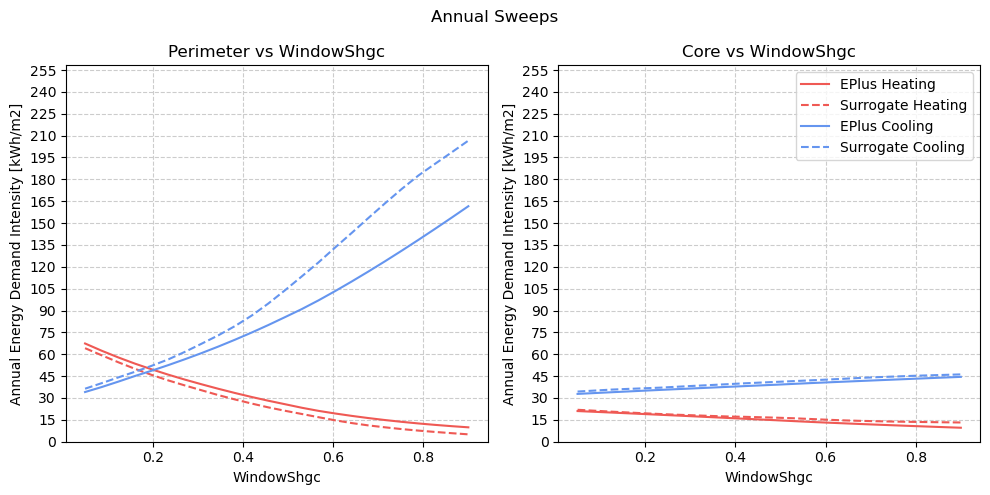

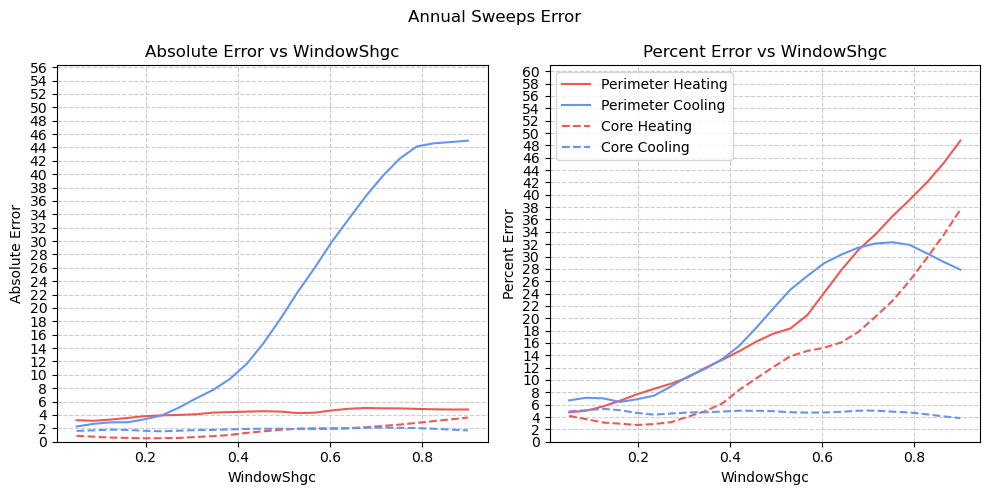

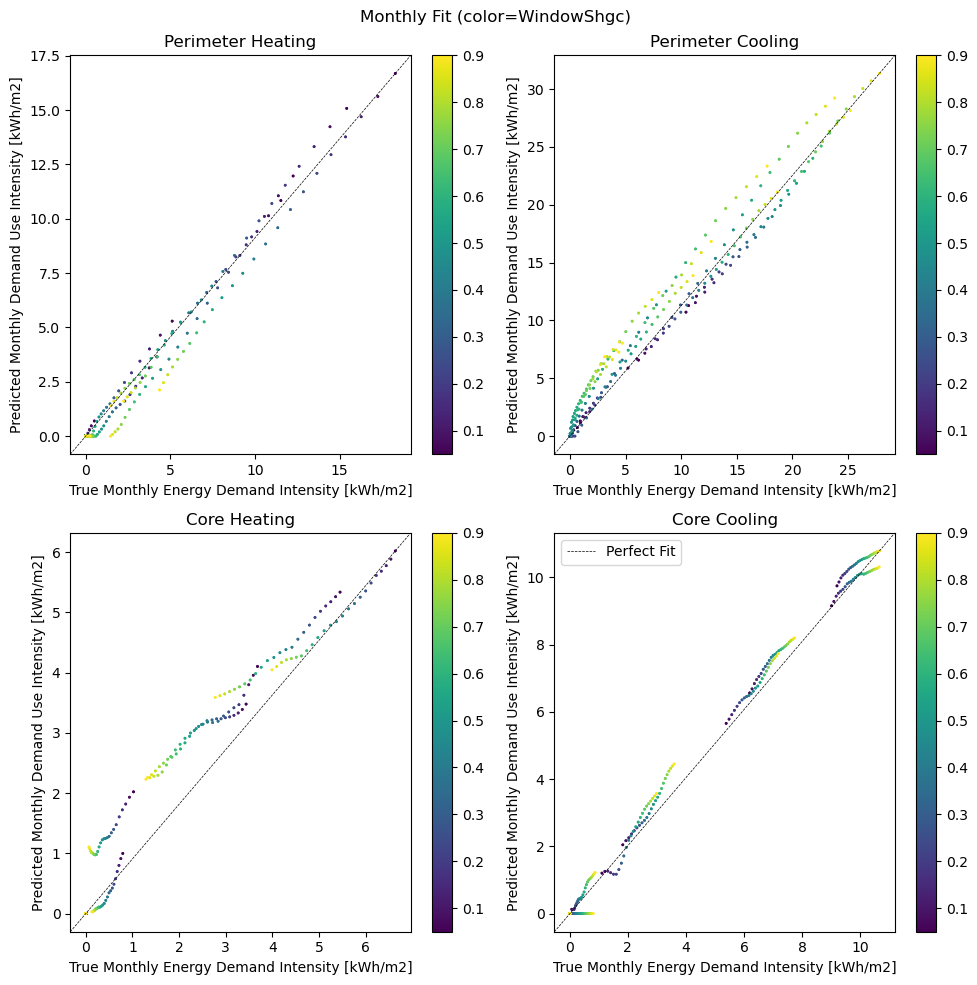

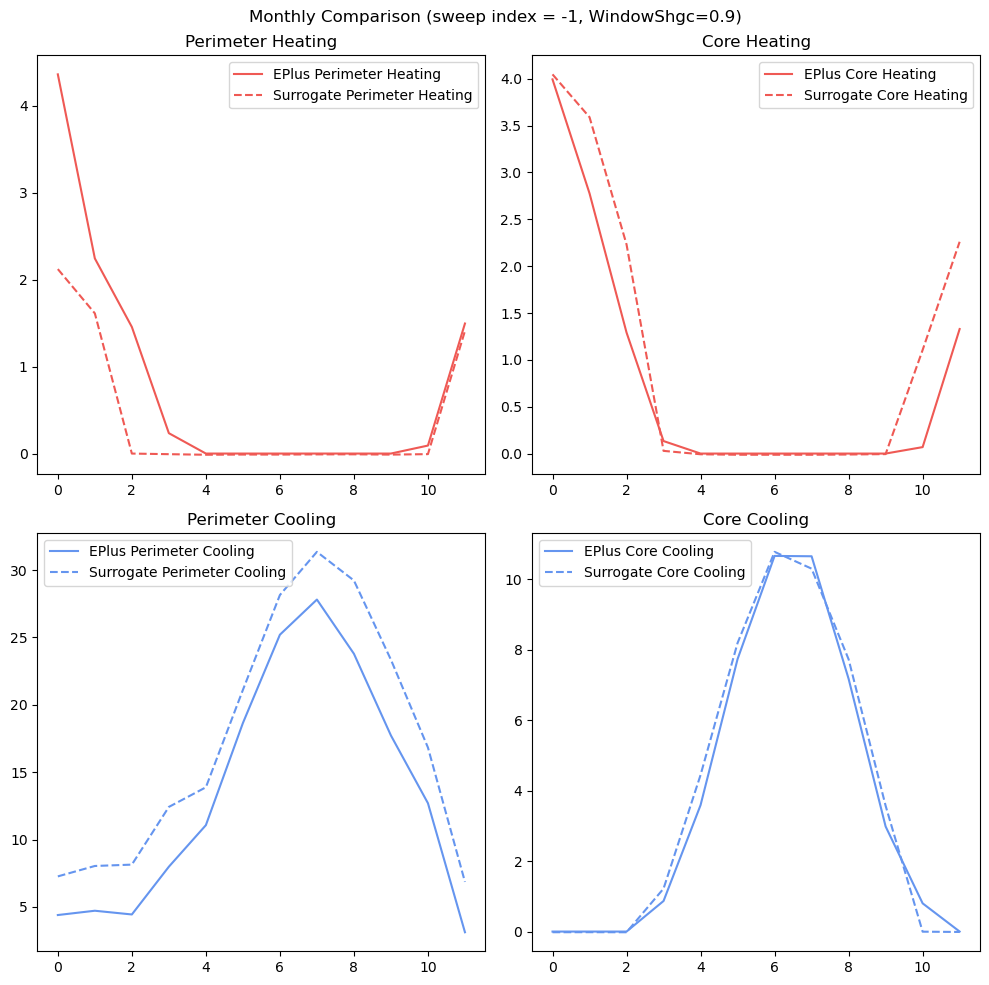

In [97]:
"""
Plot Sweep
"""
fig, axs = plt.subplots(1,2, figsize=(10,5))
absolute_max = 0
for col, zone in [(0,"Perimeter"), (1,"Core")]:
    for row, end_use, color in [(0, "Heating", "#ef5954"),( 1, "Cooling", "#6595ef" )]:
        zone_use_true = wb_shoebox_results[zone][end_use].sum(axis=1)
        zone_use = ml_shoebox_results[zone][end_use].sum(axis=1)
        absolute_max = max(absolute_max, zone_use_true.max(), zone_use.max())
        axs[col].set_title(f"{zone} vs {sweep_independent}")
        axs[col].plot(df[sweep_independent].values, zone_use_true, "-", label=f"EPlus {end_use}", color=color)
        axs[col].plot(df[sweep_independent].values, zone_use, "--", label=f"Surrogate {end_use}", color=color)
        axs[col].set_xlabel(sweep_independent)
        axs[col].set_ylabel("Annual Energy Demand Intensity [kWh/m2]")


grid_size = 5
while absolute_max / grid_size > 20:
    grid_size += 5 
axs[0].yaxis.set_major_locator(MultipleLocator(grid_size))
axs[0].grid(which='major', color='#CCCCCC', linestyle='--')
axs[1].yaxis.set_major_locator(MultipleLocator(grid_size))
axs[1].grid(which='major', color='#CCCCCC', linestyle='--')

axs[0].set_ylim([0,1.25*absolute_max])
axs[1].set_ylim([0,1.25*absolute_max])
plt.legend()
plt.suptitle("Annual Sweeps")
fig.tight_layout()

fig, axs = plt.subplots(1,2, figsize=(10,5))
plt.suptitle("Annual Sweeps Error")
absolute_error_max = 0
percent_error_max = 0
for col, zone in [(0,"Perimeter"), (1,"Core")]:
    for row, end_use, color in [(0, "Heating", "#ef5954"),( 1, "Cooling", "#6595ef" )]:
        zone_use_true = wb_shoebox_results[zone][end_use].sum(axis=1)
        zone_use = ml_shoebox_results[zone][end_use].sum(axis=1)
        errors = np.abs(zone_use_true - zone_use) 
        percent_errors = errors/zone_use_true.values*100
        absolute_error_max = max(absolute_error_max, errors.max())
        percent_error_max = max(percent_error_max, percent_errors.max())
        axs[0].plot(df[sweep_independent].values, errors, "-" if zone=="Perimeter" else "--", label=f"{zone} {end_use}", color=color)
        axs[1].plot(df[sweep_independent].values, percent_errors, "-" if zone=="Perimeter" else "--", label=f"{zone} {end_use}", color=color)
axs[0].set_title(f"Absolute Error vs {sweep_independent}")
axs[1].set_title(f"Percent Error vs {sweep_independent}")
axs[0].set_xlabel(sweep_independent)
axs[1].set_xlabel(sweep_independent)
axs[0].set_ylabel("Absolute Error")
axs[1].set_ylabel("Percent Error")
axs[0].set_ylim([0,1.25*absolute_error_max])
axs[1].set_ylim([0,1.25*percent_error_max])
# grid markers every 2 y units
grid_size = 2
axs[0].yaxis.set_major_locator(MultipleLocator(grid_size))
axs[1].yaxis.set_major_locator(MultipleLocator(grid_size))
axs[0].grid(which='major', color='#CCCCCC', linestyle='--')
axs[1].grid(which='major', color='#CCCCCC', linestyle='--')
plt.legend()
plt.suptitle("Annual Sweeps Error")
fig.tight_layout()

fig, axs = plt.subplots(2,2, figsize=(10,10))
for col, zone in [(0,"Perimeter"), (1,"Core")]:
    for row, end_use, color in [(0, "Heating", "#ef5954"),( 1, "Cooling", "#6595ef" )]:
        zone_use_true = wb_shoebox_results[zone][end_use].values.flatten()
        zone_use = np.clip(ml_shoebox_results[zone][end_use].values.flatten(),0,10000000)
        axs[col,row].set_title(f"{zone} {end_use}")
        axs[col,row].scatter(zone_use_true, zone_use,s=1, c=np.repeat(df[sweep_independent].values, 12))
        axs[col,row].set_xlabel("True Monthly Energy Demand Intensity [kWh/m2]")
        axs[col,row].set_ylabel("Predicted Monthly Demand Use Intensity [kWh/m2]")
        # show colorbar
        axs[col,row].plot([0, 1], [0, 1], transform=axs[col,row].transAxes, ls="--", c="k", lw=0.5, label="Perfect Fit")
        cbar = fig.colorbar(axs[col,row].scatter(zone_use_true, zone_use,s=1, c=np.repeat(df[sweep_independent].values, 12)))


plt.legend()
plt.suptitle(f"Monthly Fit (color={sweep_independent})")
fig.tight_layout()

ix = -1
fig, axs = plt.subplots(2,2, figsize=(10,10))
plt.suptitle(f"Monthly Comparison (sweep index = {ix}, {sweep_independent}={df[sweep_independent].values[ix]})")
for col, zone in [(0,"Perimeter"), (1,"Core")]:
    for row, end_use, color in [(0, "Heating", "#ef5954"),( 1, "Cooling", "#6595ef" )]:
        axs[row,col].set_title(f"{zone} {end_use}")
        axs[row,col].plot(wb_shoebox_results[zone][end_use].values[ix], label=f"EPlus {zone} {end_use}", color=color)
        axs[row,col].plot(ml_shoebox_results[zone][end_use].values[ix], "--", label=f"Surrogate {zone} {end_use}", color=color)
        # legend
        axs[row,col].legend()
fig.tight_layout()




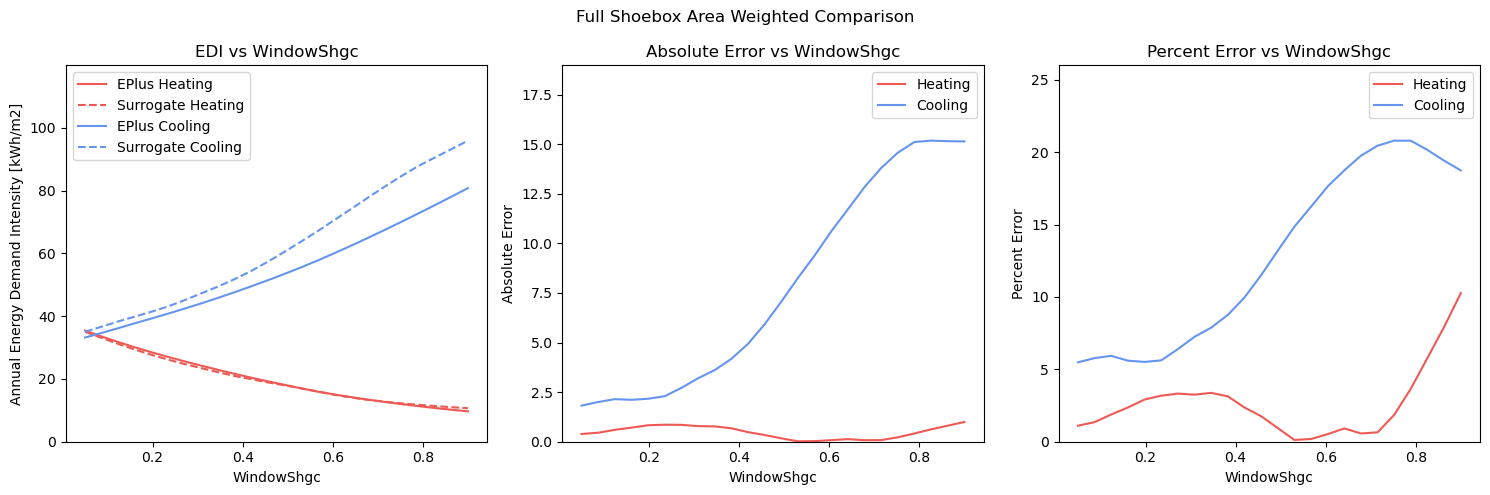

In [98]:
total_depth = df["perim_depth"] + df["core_depth"]
perim_weight = df["perim_depth"]/total_depth
core_weight = df["core_depth"] / total_depth
wb_results_weighted = wb_shoebox_results["Perimeter"] * perim_weight.values.reshape(-1,1) + wb_shoebox_results["Core"] * core_weight.values.reshape(-1,1)
ml_results_weighted = ml_shoebox_results["Perimeter"] * perim_weight.values.reshape(-1,1) + ml_shoebox_results["Core"] * core_weight.values.reshape(-1,1)

fig, axs = plt.subplots(1,3, figsize=(15,5))
plt.suptitle("Full Shoebox Area Weighted Comparison")
absolute_max = 0
absolute_error_max = 0
percent_error_max = 0
for color, end_use in [("#ef5954", "Heating"),( "#6595ef", "Cooling" )]:
    end_use_true = wb_results_weighted[end_use].sum(axis=1)
    end_use_preds = ml_results_weighted[end_use].sum(axis=1)
    errors = np.abs(end_use_true - end_use_preds)
    percent_errors = errors/end_use_true.values*100
    absolute_max = max(absolute_max, end_use_true.max(), end_use_preds.max())
    absolute_error_max = max(absolute_error_max, errors.max())
    percent_error_max = max(percent_error_max, percent_errors.max())
    axs[0].plot(df[sweep_independent].values, end_use_true, "-", label=f"EPlus {end_use}", color=color)
    axs[0].plot(df[sweep_independent].values, end_use_preds, "--", label=f"Surrogate {end_use}", color=color)
    axs[1].plot(df[sweep_independent].values, errors, "-", color=color, label=f"{end_use}")
    axs[2].plot(df[sweep_independent].values, percent_errors, "-", color=color, label=f"{end_use}")

axs[0].set_xlabel(sweep_independent)
axs[1].set_xlabel(sweep_independent)
axs[2].set_xlabel(sweep_independent)
axs[0].set_ylabel("Annual Energy Demand Intensity [kWh/m2]")
axs[0].set_title(f"EDI vs {sweep_independent}")
axs[1].set_title(f"Absolute Error vs {sweep_independent}")
axs[2].set_title(f"Percent Error vs {sweep_independent}")
axs[1].set_ylabel("Absolute Error")
axs[2].set_ylabel("Percent Error")
axs[0].set_ylim([0, absolute_max*1.25])
axs[1].set_ylim([0, absolute_error_max*1.25])
axs[2].set_ylim([0, percent_error_max*1.25])
axs[0].legend()
axs[1].legend()
axs[2].legend()

fig.tight_layout()
